# 机器学习Lab2: 回归模型
    - 姓名：王茂增
    - 学号：2113972
    - 代码：https://github.com/mzwangg/MachineLearning

## 实验要求
### 基本要求
将数据集winequality-white.csv按照4:1划分为训练集和测试集。
1. 构造线性回归模型，并采用批量梯度下降**和**随机梯度下降进行优化；输出训练集和测试集的均方误差（MSE），画出MSE收敛曲线。
1. 对于批量梯度下降**和**随机梯度下降，采用不同的学习率并进行MSE曲线展示，分析选择最佳的学习率。

特别需要注意：
- 划分数据集时尽可能保持数据分布的一致性，保持样本类别比例相似，可采用分层采样的方式。
- 需要对数据集进行一定的预处理

### 中级要求
探究回归模型在机器学习和统计学上的差异。
- 回归模型在机器学习领域和统计学领域中都十分常用，而且使用方法也相似，但其实际的含义具有本质的区别。我们希望同学们从回归模型的角度更加充分地理解机器学习和统计学的区别。


### 高级要求
编程实现岭回归算法，求解训练样本的岭回归模型，平均训练误差和平均测试误差（解析法、批量梯度下降法和随机梯度下降法**均可**）。

## 导入需要的包

In [17]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

1. 为了实验的可复现性，设置随机数种子
1. 忽略警告信息，使其不显示在控制台上。
2. 设置Matplotlib的字体为宋体（SimHei），以显示中文字符。
3. 设置Matplotlib不显示负号为Unicode字符，以确保正确显示负号。

In [18]:
np.random.seed(0)# 为了实验的可复现性，设置随机数种子
warnings.filterwarnings("ignore") # 不显示warning
plt.rcParams['font.sans-serif'] = ['SimHei'] # 显示中文
plt.rcParams['axes.unicode_minus'] = False # 显示负号

## 基本要求
将数据集winequality-white.csv按照4:1划分为训练集和测试集。
1. 构造线性回归模型，并采用批量梯度下降**和**随机梯度下降进行优化；输出训练集和测试集的均方误差（MSE），画出MSE收敛曲线。
1. 对于批量梯度下降**和**随机梯度下降，采用不同的学习率并进行MSE曲线展示，分析选择最佳的学习率。

### 数据预处理

包括标准化和归一化两种：

$$
\text { 归一化 (normalization) : } \frac{X_i-X_{\min }}{X_{\max }-X_{\min }}
$$

$$
\text { 标准化 (standardization) : } \frac{X_i-\mu}{\sigma}
$$


In [19]:
def standardize_data(data):
    # 计算均值和标准差
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    # 防止除以零的情况，如果某列的标准差为0，将其替换为1
    std[std == 0] = 1
    # 标准化数据
    data = (data - mean) / std
    return data

def normalization_data(data):
    # 计算均值、最大值、最小值
    mean = np.mean(data, axis=0)
    max = np.max(data, axis=0)
    min = np.min(data, axis=0)
    # 防止除以零的情况，如果某列的标准差为0，将其替换为1
    max[max == min] = min[max == min] + 1
    # 归一化数据
    data = (data - mean) / (max - min)
    return data

进行数据预处理

In [20]:
# 数据预处理
data = np.genfromtxt('winequality-white.csv', delimiter=',', skip_header=1) # 读取数据
X = data[:, :-1]  # 特征
y = data[:, -1].reshape(-1,1)  # 目标（quality）
X = normalization_data(X) # 进行数据归一化

可视化归一化结果

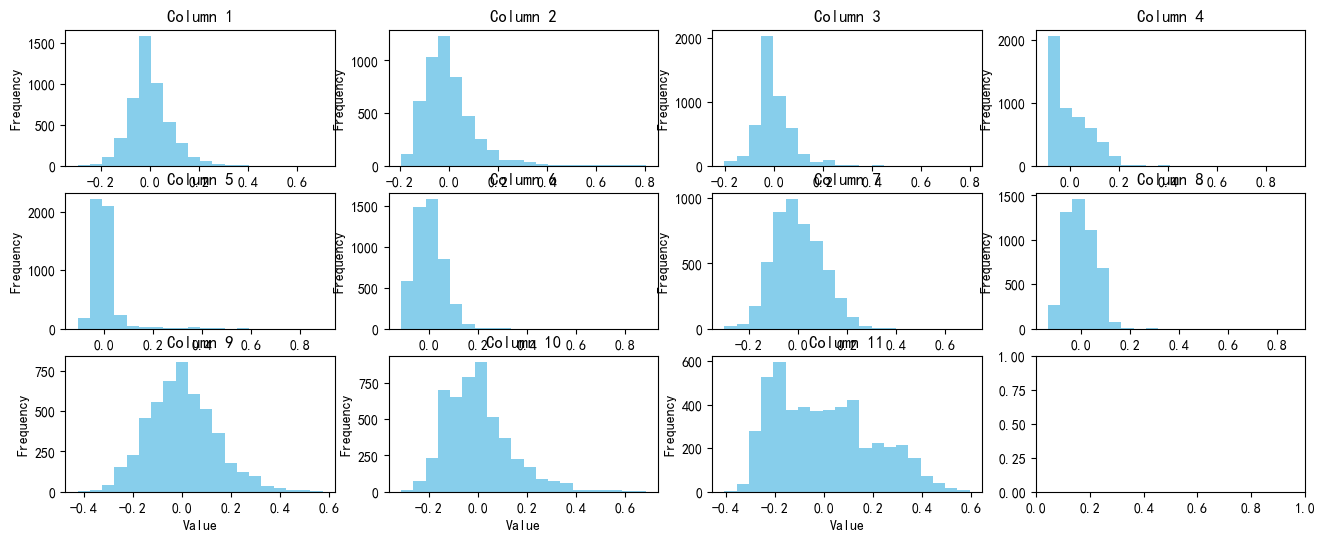

In [21]:
# 创建子图，以 3 行 4 列的方式排列直方图
_, axes = plt.subplots(3, 4, figsize=(16, 6))
# 将二维子图数组展平，以便遍历
axes = axes.ravel()
# 遍历列，并绘制直方图
for i in range(X.shape[1]):
    ax = axes[i]
    ax.hist(X[:, i], bins=20, color='skyblue')
    ax.set_title(f'Column {i + 1}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
plt.show()

### 分层抽样

对不同quality的数据分别按相同比例划分训练集和测试集并合并

In [22]:
def train_test_split(X, y, train_rate=0.8):
    # 找出 quality 列的值的种类
    unique_values, counts = np.unique(y, return_counts=True)
    # 初始化训练集和测试集
    train_indices = []
    test_indices = []
    # 对于每个唯一的 quality 值，进行分层抽样
    for value, count in zip(unique_values, counts):
        indices = np.where(y == value)[0] # 找到等于该quality的所有数据
        np.random.shuffle(indices) # 打乱
        split_point = int(train_rate * count) # 划分点
        train_indices.extend(indices[:split_point]) # 训练集
        test_indices.extend(indices[split_point:]) # 测试集
    return X[train_indices], y[train_indices], X[test_indices], y[test_indices]

# 进行分层抽样
X_train, y_train, X_test, y_test = train_test_split(X, y, train_rate=0.8)

展示分层抽样结果

分层抽样结果展示：


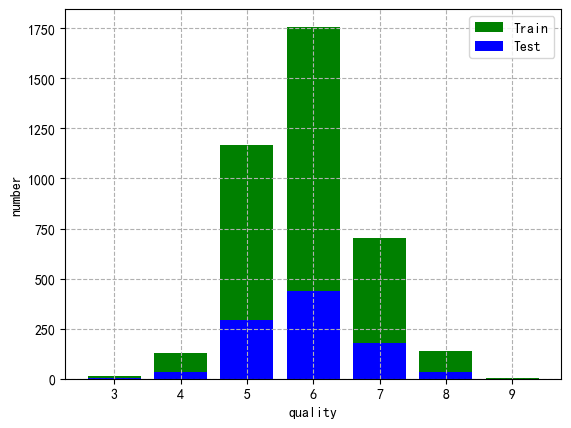

In [23]:
# 展示分层抽样的结果
print("分层抽样结果展示：")
unique_values, counts = np.unique(y_train, return_counts=True)
plt.bar(unique_values, counts, color='g', label='Train')
unique_values, counts = np.unique(y_test, return_counts=True)
plt.bar(unique_values, counts, color='b', label='Test')
plt.grid(linestyle="--")
plt.xlabel("quality")
plt.ylabel("number")
plt.legend()
# 显示图
plt.show()

添加偏置列并初始化权重

In [24]:
# 添加偏置列
X_train = np.c_[np.ones((X_train.shape[0], 1)), X_train]
X_test = np.c_[np.ones((X_test.shape[0], 1)), X_test]

# 初始化权重
weights = np.random.randn(X_train.shape[1], 1)

### 构建线性回归模型

编写预测和计算mse的函数

In [25]:
# 线性回归模型
def predict(X, weights):
    return np.dot(X, weights)

# 计算MSE
def calculate_mse(X, y, weights):
    predictions = predict(X, weights)
    mse = np.mean((y - predictions) ** 2)/2
    return mse

#### 批量梯度下降

通过numpy一次计算所有数据的梯度并取平均，然后进行梯度下降。

In [26]:
# 批量梯度下降
def batch_gradient_descent(weights, X_train, y_train, X_test, y_test, learning_rate = 0.05, num_epochs = 100):
    bgd_weights = np.copy(weights)
    num_samples, num_features = X_train.shape
    bgd_train_mse = [calculate_mse(X_train, y_train, bgd_weights)]
    bgd_test_mse = [calculate_mse(X_test, y_test, bgd_weights)]

    # 初始化最优mse和权重
    best_mse = bgd_train_mse[0]
    best_weights = bgd_weights

    # 进行批量梯度下降
    for epochs in range(1, num_epochs+1):
        # 计算梯度
        gradient = -(1/num_samples) * np.dot((y_train - predict(X_train, bgd_weights)).T, X_train).T
        # 梯度下降
        bgd_weights -= learning_rate * gradient
        # 记录历史mse
        bgd_train_mse.append(calculate_mse(X_train, y_train, bgd_weights))
        bgd_test_mse.append(calculate_mse(X_test, y_test, bgd_weights))
        # 保存最优参数
        if(bgd_train_mse[epochs]<best_mse):
            best_mse = bgd_train_mse[epochs]
            best_weights = bgd_weights

    return best_weights, bgd_train_mse, bgd_test_mse

#### 随机梯度下降

先将数据进行打乱，然后一个一个计算梯度并进行梯度下降。

In [27]:
# 随机梯度下降
def stochastic_gradient_descent(weights, X_train, y_train, X_test, y_test, learning_rate = 0.00001, num_epochs = 100):
    sgd_weights = np.copy(weights)
    num_samples, num_features = X_train.shape
    sgd_train_mse = [calculate_mse(X_train, y_train, sgd_weights)]
    sgd_test_mse = [calculate_mse(X_test, y_test, sgd_weights)]

    # 初始化最优mse和权重
    best_mse = sgd_train_mse[0]
    best_weights = sgd_weights

    # 创建一个随机索引
    random_indexs = np.random.permutation(num_samples)

    # 进行随机梯度下降
    for epochs in range(1, num_epochs+1):
        for random_index in random_indexs:
            xi = X_train[random_index].reshape(1,-1)
            yi = y_train[random_index].reshape(1,-1)
            # 计算梯度
            gradient = -(yi - predict(xi, sgd_weights)) * xi
            # 梯度下降
            sgd_weights -= learning_rate * gradient.T
        # 记录历史mse
        sgd_train_mse.append(calculate_mse(X_train, y_train, sgd_weights))
        sgd_test_mse.append(calculate_mse(X_test, y_test, sgd_weights))
        # 保存最优参数
        if(sgd_train_mse[epochs]<best_mse):
            best_mse = sgd_train_mse[epochs]
            best_weights = sgd_weights

    return best_weights, sgd_train_mse, sgd_test_mse

### 进行实验

输出训练集和测试集的均方误差（MSE），画出MSE收敛曲线。

Batch Gradient Descent - MSE (Train): 0.3566037984996902
Batch Gradient Descent - MSE (Test): 0.3504127193530425
Stochastic Gradient Descent - MSE (Train): 0.3654984918604313
Stochastic Gradient Descent - MSE (Test): 0.3599756872216837


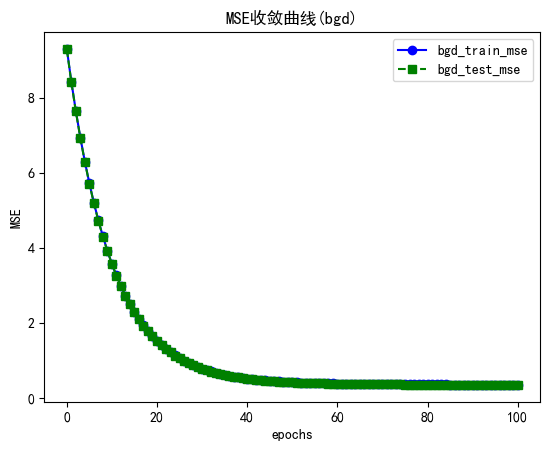

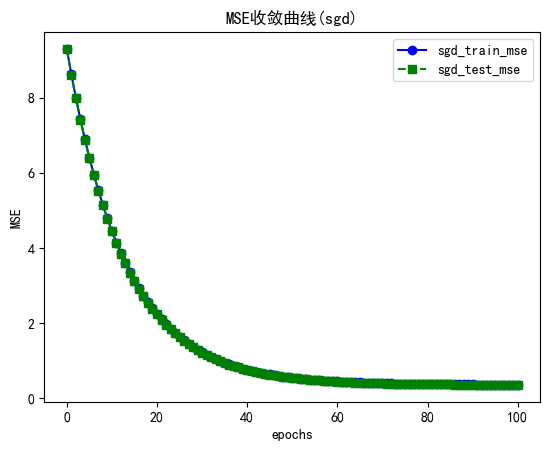

In [28]:
# 批量梯度下降
bgd_weights, bgd_train_mse, bgd_test_mse = batch_gradient_descent(weights, X_train, y_train, X_test, y_test)

# 随机梯度下降
sgd_weights, sgd_train_mse, sgd_test_mse = stochastic_gradient_descent(weights, X_train, y_train, X_test, y_test)

# 计算MSE
mse_train_bgd = calculate_mse(X_train, y_train, bgd_weights)
mse_test_bgd = calculate_mse(X_test, y_test, bgd_weights)
mse_train_sgd = calculate_mse(X_train, y_train, sgd_weights)
mse_test_sgd = calculate_mse(X_test, y_test, sgd_weights)
print(f"Batch Gradient Descent - MSE (Train): {mse_train_bgd}")
print(f"Batch Gradient Descent - MSE (Test): {mse_test_bgd}")
print(f"Stochastic Gradient Descent - MSE (Train): {mse_train_sgd}")
print(f"Stochastic Gradient Descent - MSE (Test): {mse_test_sgd}")

plt.plot(bgd_train_mse, label='bgd_train_mse', color='b', marker='o', linestyle='-')
plt.plot(bgd_test_mse, label='bgd_test_mse', color='g', marker='s', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.title("MSE收敛曲线(bgd)")
plt.legend()# 添加图例
plt.show()

# 绘制第一条折线
plt.plot(sgd_train_mse, label='sgd_train_mse', color='b', marker='o', linestyle='-')
plt.plot(sgd_test_mse, label='sgd_test_mse', color='g', marker='s', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.title("MSE收敛曲线(sgd)")
plt.legend()# 添加图例
plt.show()

由上面的信息可知，使用BGD和SGD在100轮的训练中均达到了收敛，且BGD的MSE要略优于SGD，这是由于SGD一次只使用一个样本进行训练，并不一定能获得全局最优。另外，可以看到训练集和测试集的mse差距不大，表明模型没有出现过拟合的情况。甚至可以看到测试集的MSE的效果要略优于测试集，猜测是由于随机划分数据集而导致的偶然情况，即虽然参数是在train数据集训练的但是更适合test数据集。

#### 分析最佳学习率

采用不同的学习率并进行MSE曲线展示，分析选择最佳的学习率。

##### 批量梯度下降

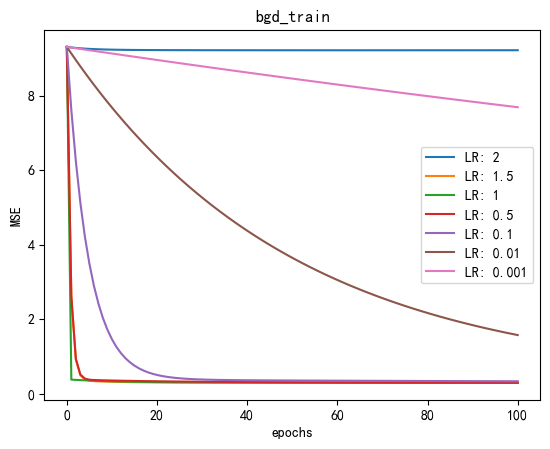

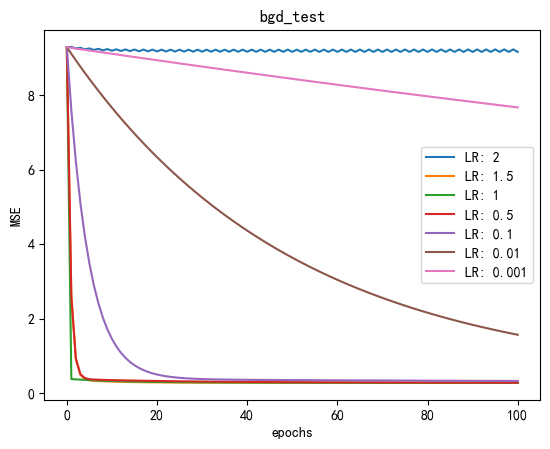

bgd_mse:  [9.166062622415067, 0.2739990273068375, 0.2754162925485206, 0.28058572521205377, 0.32674738435890366, 1.567960151338546, 7.674893298600695]
bgd_best_msc: 0.2739990273068375, bgd_best_lr:1.5


In [29]:
# 训练轮数
num_epochs = 100
# 学习率
learning_rates = [2, 1.5, 1, 0.5, 0.1, 0.01, 0.001]
# 用于记录历史数据
bgd_train = []
bgd_test = []
bgd_mse=[]

for learning_rate in learning_rates:
    # 批量梯度下降
    bgd_weights, bgd_train_mse, bgd_test_mse = batch_gradient_descent(weights, X_train, y_train, X_test, y_test, learning_rate=learning_rate, num_epochs=num_epochs)
    # 记录历史数据
    bgd_train.append(bgd_train_mse)
    bgd_test.append(bgd_test_mse)
    bgd_mse.append(calculate_mse(X_test, y_test, bgd_weights))

# 绘制bgd_train的图像
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.title("bgd_train")
for i in range(len(learning_rates)):
    plt.plot(bgd_train[i], label=f"LR: {learning_rates[i]}")
plt.legend()
plt.show()

# 绘制bgd_test的图像
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.title("bgd_test")
for i in range(len(learning_rates)):
    plt.plot(bgd_test[i], label=f"LR: {learning_rates[i]}")
plt.legend()
plt.show()

# 输出各个学习率的最优MSE
print("bgd_mse: ", bgd_mse)
# 输出BGD和SGD的最优学习率
print(f"bgd_best_msc: {bgd_mse[np.argmin(bgd_mse)]}, bgd_best_lr:{learning_rates[np.argmin(bgd_mse)]}")

##### 随机梯度下降

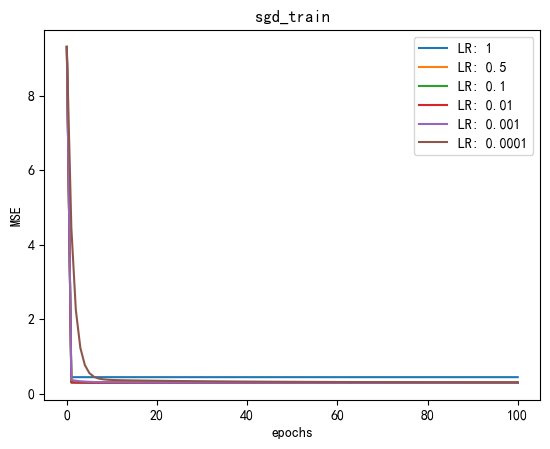

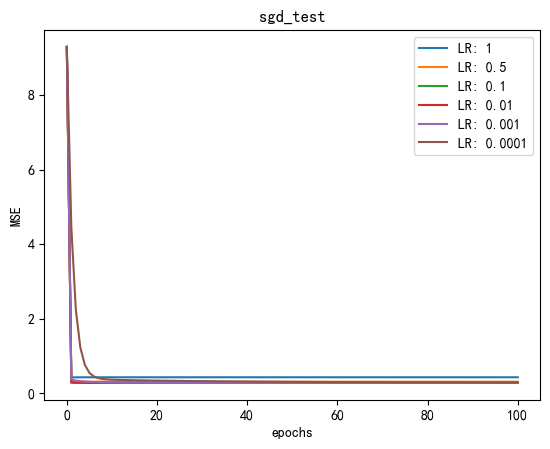

sgd_mse:  [0.4246385503327514, 0.3069879675815693, 0.28130689600623476, 0.27352285705759927, 0.27339463153964866, 0.28416857690403013]
sgd_best_msc: 0.27339463153964866, sgd_best_lr:0.001


In [30]:
# 训练轮数
num_epochs = 100
# 学习率
learning_rates = [1, 0.5, 0.1, 0.01, 0.001, 0.0001]
# 用于记录历史数据
sgd_train = []
sgd_test = []
sgd_mse=[]

for learning_rate in learning_rates:
    # 随机梯度下降
    sgd_weights, sgd_train_mse, sgd_test_mse = stochastic_gradient_descent(weights, X_train, y_train, X_test, y_test, learning_rate=learning_rate, num_epochs=num_epochs)
    # 记录历史数据
    sgd_train.append(sgd_train_mse)
    sgd_test.append(sgd_test_mse)
    sgd_mse.append(calculate_mse(X_test, y_test, sgd_weights))

# 绘制sgd_train的图像
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.title("sgd_train")
for i in range(len(learning_rates)):
    plt.plot(sgd_train[i], label=f"LR: {learning_rates[i]}")
plt.legend()
plt.show()

# 绘制sgd_test的图像
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.title("sgd_test")
for i in range(len(learning_rates)):
    plt.plot(sgd_test[i], label=f"LR: {learning_rates[i]}")
plt.legend()
plt.show()

# 输出各个学习率的最优MSE
print("sgd_mse: ", sgd_mse)
# 输出BGD和SGD的最优学习率
print(f"sgd_best_msc: {sgd_mse[np.argmin(sgd_mse)]}, sgd_best_lr:{learning_rates[np.argmin(sgd_mse)]}")

#### 不同学习率对MSE曲线影响分析

由图可知，对于BGD来说，当学习率较小时模型收敛会十分缓慢，而当学习率过大时又会难以收敛到最值，当学习率处于0.1~1.5之间时，MSE曲线收敛效果较好。对于SGD来说, 由于每个epoch均会多次进行梯度下降，当学习率较大时, 模型的收敛结果不好，难以收敛到最值，其中当学习率取0.001时有最优的MSE, 为0.2735。而BGD的最优结果为0.2739，几乎一致，表明两种方法均能较好地求解线性回归模型。

## 三. 中级要求
### 回归模型在机器学习和统计学上的差异

1. **目标**：
   - 机器学习：在机器学习中，重点通常是构建模型，以最小化预测误差。所以回归模型通常用于预测或估计目标变量（连续型变量），例如房屋价格、股票价格、销售量等。
   - 统计学：在统计学中，重点通常是推断、假设检验和参数估计。所以回归模型通常用于分析自变量和因变量之间的关系，以理解变量之间的相关性和因果关系。

2. **方法**：
   - 机器学习：机器学习中的回归模型通常使用多种算法，如线性回归、决策树回归、支持向量回归、神经网络等，以训练模型并进行预测。
   - 统计学：统计学中的回归模型通常基于统计理论和假设，如普通最小二乘法（OLS）回归、广义线性模型（GLM）、回归分析等，以分析数据中的关系、变化和不确定性

3. **特征选择**：
   - 机器学习：机器学习通常涉及大规模特征选择和特征工程，以从大量特征中提取最有用的信息，以提高预测性能。
   - 统计学：统计学中通常更加注重理论和先验知识，特征选择可能更为谨慎，侧重于解释模型的可解释性。

4. **模型评估**：
   - 机器学习：机器学习通常使用交叉验证、均方误差（MSE）、均方根误差（RMSE）、决定系数（R-squared）等指标来评估模型的性能，以选择最佳模型。
   - 统计学：统计学通常会进行假设检验、置信区间分析、残差分析等，以评估模型是否与数据拟合得很好，以及自变量是否显著影响因变量。

5. **应用领域**：
   - 机器学习：机器学习的应用范围非常广泛，包括自然语言处理、计算机视觉、推荐系统、金融预测等多个领域。
   - 统计学：统计学的应用范围也广泛，但通常更关注科学研究、社会科学和公共卫生等领域。

## 四. 高级要求
岭回归求解 :
$$
\mathrm{w}=\left(X^T X+\lambda I\right)^{-1} X^T \mathrm{y}
$$
$\lambda$ 为岭系数。

故根据以上公式实现如下函数：

In [31]:
def ridge_regression(X_train, y_train, L2_lambda = 0.2):  # 设置岭系数为0.2
    x_mat = np.mat(X_train)
    y_mat = np.mat(y_train)
    xTx = x_mat.T * x_mat
    rxTx = xTx + np.eye(x_mat.shape[1]) * L2_lambda
    # 计算矩阵的值,如果值为0，说明该矩阵没有逆矩阵
    if np.linalg.det(rxTx) == 0.0:
        return
    return np.array(rxTx.I * x_mat.T * y_mat)

下面对于不同的$\lambda$，计算其平均训练误差和平均测试误差：

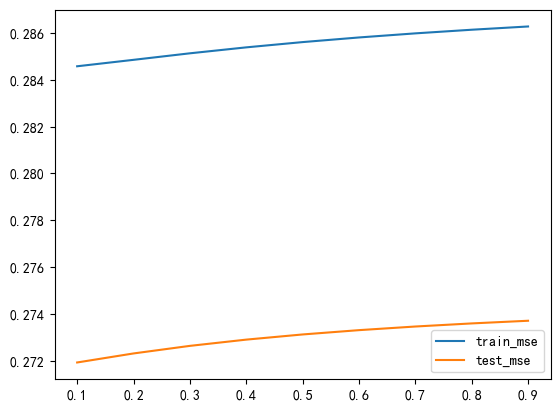

train_best_msc: 0.2845770401305389, train_best_lambda:0.1
test_best_msc: 0.2719315822853224, test_best_lambda:0.1


In [32]:
train_mse = []
test_mse = []
L2_lambdas=np.arange(0.1, 1, 0.1)

# 下面对于不同的lambda，计算其平均训练误差和平均测试误差
for L2_lambda in L2_lambdas:
    ridge_weights = ridge_regression(X_train, y_train, L2_lambda)
    train_mse.append(calculate_mse(X_train, y_train, ridge_weights))
    test_mse.append(calculate_mse(X_test, y_test, ridge_weights))

plt.plot(L2_lambdas, train_mse, label="train_mse")
plt.plot(L2_lambdas, test_mse, label="test_mse")
plt.legend()
plt.show()

# 输出train和test的最优学习率
print(f"train_best_msc: {train_mse[np.argmin(train_mse)]}, train_best_lambda:{L2_lambdas[np.argmin(train_mse)]}")
print(f"test_best_msc: {test_mse[np.argmin(test_mse)]}, test_best_lambda:{L2_lambdas[np.argmin(test_mse)]}")

由结果可知，当$\lambda$在0.1时效果最好。

由于BGD的测试集最低误差为0.2739，SGD测试集的最低误差为0.2735，而岭回归的测试集最低误差为0.2719。所以岭回归的性能最优。原因在于BGD和SGD是基于梯度下降算法计算的，都不一定能收敛到全局最小值，而岭回归通过解析法计算，一定能收敛到全局最小值。